In [1]:
from colocation import *
%matplotlib inline

# load data

In [2]:
start = '2016-08-07 00:00:00'
end = '2016-09-22 00:00:00'

def filter_by_time(df):
    time = (df.datetime > start) & (df.datetime < end)
    return df[time]

In [3]:
# load airpublic data

def clean(df):
    df['datetime'] = pd.to_datetime(df.timestamp)
    df['timestamp'] = pd.to_datetime(df.timestamp)    
    
    df = df.sort_values(by='datetime')
    
    sane_gps = (df.latitude > 0) & (df.gps_fix == 1)
    # Marylebeone site has code MY1 and these GPS coords
    my1_site = (df.longitude > -0.155) & (df.longitude <  -0.154) & (df.latitude > 51.52) &  (df.latitude < 51.53 )
    cleaned_df = df[sane_gps & my1_site]
    count_clean = len(cleaned_df)
    count_all = len(df)
    print('Removed %s rows' % (count_all - count_clean))
    print('Remaining %s rows' % (count_clean))
    
    # Warning: the computer timezone must be gmt in order to match kings
    # assuming only one sensor
    cleaned_df = cleaned_df.set_index('datetime')  
    
    return cleaned_df

In [4]:
df_airpublic = pd.read_csv('airpublic_sensor.csv')
df_airpublic = clean(df_airpublic)
ds = xr.Dataset.from_dataframe(df_airpublic)
ds_mean = ds.resample(freq='1H', dim='datetime', how='mean', skipna=True)

Removed 4679 rows
Remaining 37247 rows


In [5]:
# load kings

df_kings = pd.read_csv('kings_sensor.csv')

def prep_kings(df_kings):
    df_kings['datetime'] = pd.to_datetime(df_kings.date)    
    df_kings = filter_by_time(df_kings)    
    df_kings = df_kings.set_index('datetime')    
    ds_kings = xr.Dataset.from_dataframe(df_kings)
    return ds_kings

ds_kings = prep_kings(df_kings)

In [6]:
ds_merged = xr.merge([ds_kings[['pm10', 'pm10_raw']].rename({'pm10': 'kings_vol_pm10', 'pm10_raw': 'kings_vol_pm10_raw'}), ds_mean], join='inner')

# pm 10

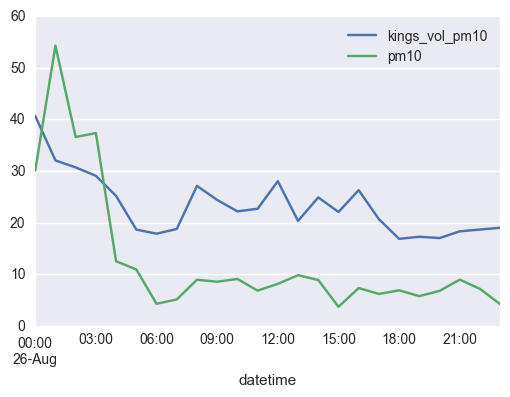

In [7]:
ds_merged_pm10 = ds_merged[['kings_vol_pm10','pm10']]
ds_merged_pm10.sel(datetime='2016-08-26').to_dataframe().plot()

Coefficients: 
 [[ 0.33629136]] [ 22.6428407]
Mean squared error: 42.79
Variance score: 0.38
R2 score: 0.039


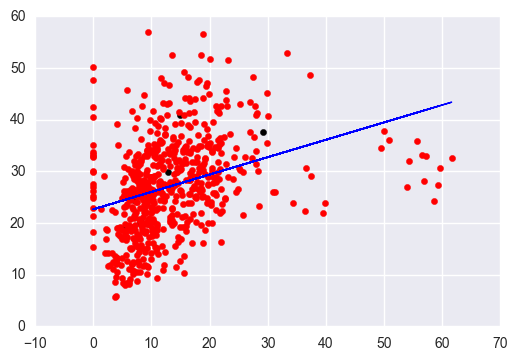

In [21]:
m, c = linear_regr_fudge(ds_merged, 'pm10', 'kings_vol_pm10', test_size=0.01, split='random')

            pm10  pm10_modified
count  24.000000      24.000000
mean   12.886713      26.976531
std    12.925249       4.346650
min     3.744909      23.902221
25%     6.672827      24.886855
50%     8.388132      25.463697
75%    10.140239      26.052916
max    54.283548      40.897929
r2 score:  -0.680493888418
Probability that they belong to the same distribution (KS p-value):  2.5984625573e-08


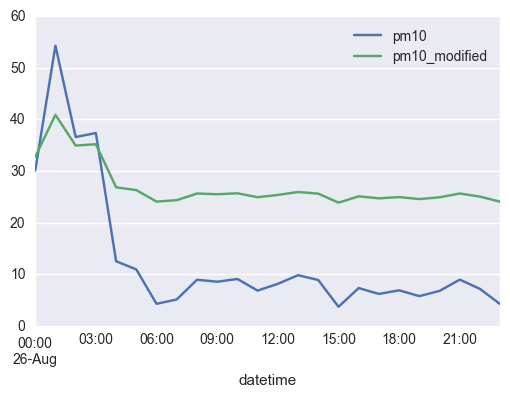

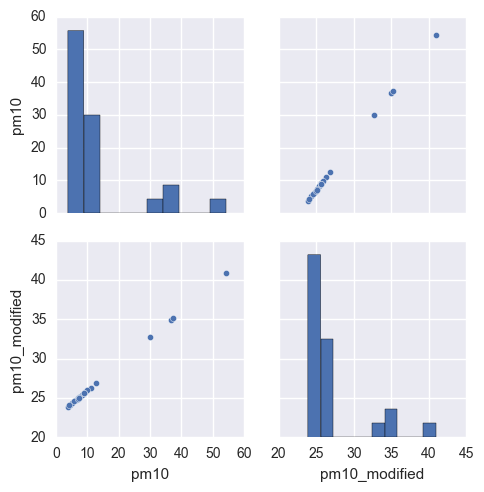

In [23]:
# plot the result
ds_merged['pm10_modified'] = ds_merged['pm10'] * m[0][0] + c[0]
compare(ds_merged.sel(datetime='2016-08-26'),'pm10','pm10_modified')

Coefficients: 
 [[ 0.3738401]] [ 20.39224738]
Mean squared error: 84.23
Variance score: -0.10
R2 score: 0.058


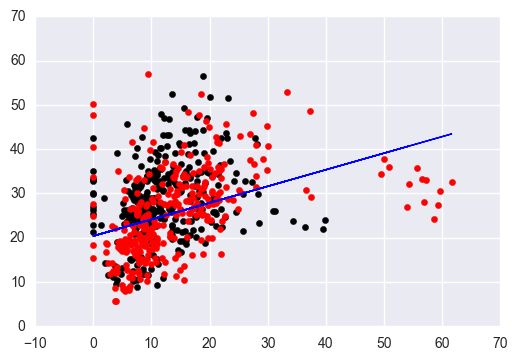

In [25]:
m, c = linear_regr_fudge(ds_merged, 'pm10', 'kings_vol_pm10', test_size=0.5, split='chronological')

            pm10  pm10_modified
count  24.000000      24.000000
mean   12.886713      25.209817
std    12.925249       4.831976
min     3.744909      21.792245
25%     6.672827      22.886818
50%     8.388132      23.528067
75%    10.140239      24.183075
max    54.283548      40.685614
r2 score:  -0.34059478092
Probability that they belong to the same distribution (KS p-value):  2.5984625573e-08


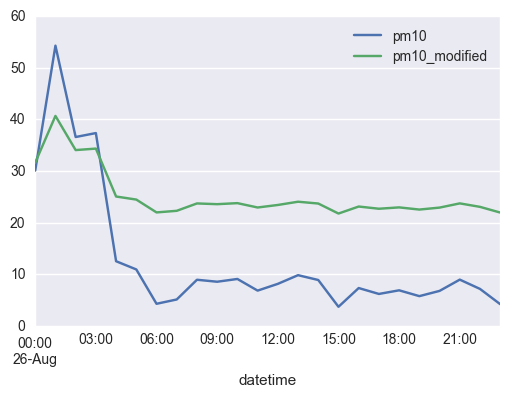

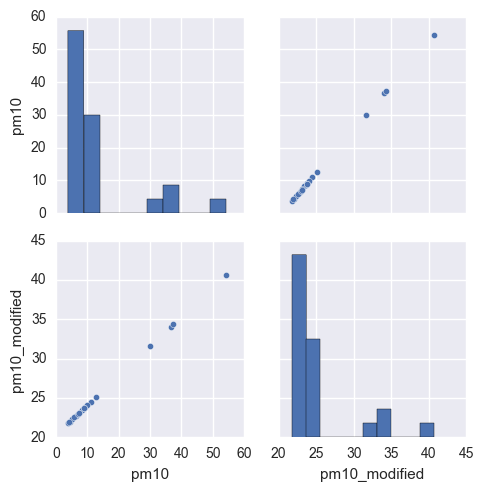

In [26]:
# plot the result
ds_merged['pm10_modified'] = ds_merged['pm10'] * m[0][0] + c[0]
compare(ds_merged.sel(datetime='2016-08-26'),'pm10','pm10_modified')